In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [25]:
import kagglehub
import os

path = kagglehub.dataset_download(
    "ankurzing/sentiment-analysis-for-financial-news"
)

csv_path = os.path.join(path, "all-data.csv")

df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    sep=",",
    header=None,
    names=["label", "text"]
)

df.head()


,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [26]:
df["label"] = (
    df["label"]
    .astype(str)
    .str.strip()
    .str.lower()
)

label_map = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

df["label"] = df["label"].map(label_map)

df["label"].value_counts()


label
2    2879
0    1363
1     604
Name: count, dtype: int64

In [30]:
class FeatureExtractor:
    def __init__(self, max_features=5000, ngram_range=(1, 2)):
        self.max_features = max_features
        self.ngram_range = ngram_range
        
        self.bow_vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.8,
            stop_words="english"
        )
        
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.8,
            stop_words="english"
        )
    
    def fit_transform_bow(self, texts):
        X = self.bow_vectorizer.fit_transform(texts)
        features = self.bow_vectorizer.get_feature_names_out()
        return X, features
    
    def fit_transform_tfidf(self, texts):
        X = self.tfidf_vectorizer.fit_transform(texts)
        features = self.tfidf_vectorizer.get_feature_names_out()
        return X, features
    
    def get_top_features(self, vectorizer, X, n=20):
        avg_scores = X.toarray().mean(axis=0)
        features = vectorizer.get_feature_names_out()
        top_idx = np.argsort(avg_scores)[::-1][:n]
        return [(features[i], avg_scores[i]) for i in top_idx]
    
    def visualize_top_features(self, vectorizer, X, n=20):
        top = self.get_top_features(vectorizer, X, n)
        names = [x[0] for x in top][::-1]
        scores = [x[1] for x in top][::-1]
        
        plt.figure(figsize=(7, 4))
        plt.barh(names, scores)
        plt.xlabel("Average TF-IDF Score")
        plt.title("Top TF-IDF Features")
        plt.tight_layout()
        plt.show()


In [31]:
fe = FeatureExtractor(
    max_features=5000,
    ngram_range=(1, 2)
)


In [32]:
X_bow, bow_features = fe.fit_transform_bow(df.text)

print("FEATURE EXTRACTION RESULTS")
print("═══════════════════════════════════════════════════════════")
print("BoW Shape:", X_bow.shape)


FEATURE EXTRACTION RESULTS
═══════════════════════════════════════════════════════════
BoW Shape: (4846, 5000)


In [33]:
X_tfidf, tfidf_features = fe.fit_transform_tfidf(df.text)

print("TF-IDF Shape:", X_tfidf.shape)
print("Vocabulary Size:", len(tfidf_features))


TF-IDF Shape: (4846, 5000)
Vocabulary Size: 5000


In [34]:
top_features = fe.get_top_features(
    fe.tfidf_vectorizer,
    X_tfidf,
    n=20
)

print("Top 20 Most Informative Features (by average TF-IDF):")
for i, (feat, score) in enumerate(top_features, 1):
    print(f"{i:2d}. {feat:<15} (avg_tfidf: {score:.4f})")


Top 20 Most Informative Features (by average TF-IDF):
 1. eur             (avg_tfidf: 0.0255)
 2. company         (avg_tfidf: 0.0214)
 3. mn              (avg_tfidf: 0.0161)
 4. said            (avg_tfidf: 0.0145)
 5. sales           (avg_tfidf: 0.0143)
 6. million         (avg_tfidf: 0.0136)
 7. year            (avg_tfidf: 0.0126)
 8. finnish         (avg_tfidf: 0.0124)
 9. net             (avg_tfidf: 0.0119)
10. profit          (avg_tfidf: 0.0118)
11. finland         (avg_tfidf: 0.0115)
12. operating       (avg_tfidf: 0.0100)
13. group           (avg_tfidf: 0.0100)
14. new             (avg_tfidf: 0.0097)
15. 2009            (avg_tfidf: 0.0096)
16. 2008            (avg_tfidf: 0.0095)
17. business        (avg_tfidf: 0.0095)
18. mln             (avg_tfidf: 0.0090)
19. net sales       (avg_tfidf: 0.0089)
20. 2007            (avg_tfidf: 0.0087)


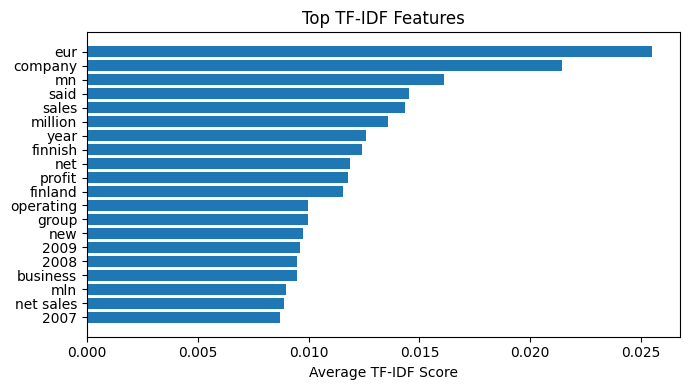

In [35]:
fe.visualize_top_features(
    fe.tfidf_vectorizer,
    X_tfidf,
    n=20
)


In [36]:
sample = ["strong profit growth"]

bow_sample = fe.bow_vectorizer.transform(sample).toarray()[0]
tfidf_sample = fe.tfidf_vectorizer.transform(sample).toarray()[0]

print("Sample:", sample[0])

print("BoW features:")
for i in np.where(bow_sample > 0)[0]:
    print(f"{bow_features[i]} = {bow_sample[i]}")

print("\nTF-IDF features:")
for i in np.where(tfidf_sample > 0)[0]:
    print(f"{tfidf_features[i]} = {tfidf_sample[i]:.4f}")


Sample: strong profit growth
BoW features:
growth = 1
profit = 1
strong = 1

TF-IDF features:
growth = 0.6013
profit = 0.3948
strong = 0.6947
